# Spectrogram Visualization

In [ ]:
import fcwt
import librosa
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Load the audio file

audio_path = 'data/snare.wav'
y, sr = librosa.load(audio_path, sr=None)
print(y.shape, sr)
y = y[:int(sr * 1)]


In [ ]:
# plot the audio signal
plt.figure()
plt.plot(y)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Audio Signal')
plt.show()

In [ ]:
import IPython

IPython.display.Audio(y, rate=sr)

In [ ]:
# Compute the CWT
fn = 500
freqs, cwt = fcwt.cwt(y, sr, 20, 20000, fn, scaling='log', fast=True, norm=True)
print(cwt.shape)
cwt = np.abs(cwt) ** 2

In [ ]:
# Visualize the CWT
use_db_scale = True
cwt_dB = librosa.power_to_db(cwt, ref=np.max)
signal = cwt if not use_db_scale else cwt_dB
fig, ax = plt.subplots()
img = ax.imshow(signal, aspect='auto', cmap='inferno')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')
ax.set_title('CWT')
# ax.set_xticks(np.linspace(0,cwt_dB.size,10),np.arange(0,cwt_dB.size/sr,10))
ax.set_yticks(np.arange(0, fn, fn / 10), np.round(freqs[::int(fn / 10)]))
fig.colorbar(img, ax=ax, format='%+2.0f dB')
plt.show()

In [ ]:
# show stft of the same signal
hop_length = 256
S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=4096, hop_length=hop_length, n_mels=512)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
signal = S_dB if use_db_scale else S
img = librosa.display.specshow(signal, x_axis='time',
                               y_axis='mel', sr=sr,
                               fmin=20,
                               fmax=20000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')
plt.show()

# Dataset Stats

In [ ]:
import pretty_midi
import numpy as np
from dataset.A2MD import get_tracks
from dataset import get_drums
from dataset.mapping import DrumMapping
import os
import polars as pl
import json
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['svg.fonttype'] = 'none'

In [ ]:
def get_drum_pitch_velocity(path) -> np.ndarray:
    midi = pretty_midi.PrettyMIDI(
        midi_file=path
    )
    drum_instruments: list[pretty_midi.Instrument] = [
        instrument for instrument in midi.instruments if instrument.is_drum
    ]
    notes = np.array(
        [
            (note.pitch, note.velocity)
            for instrument in drum_instruments
            for note in instrument.notes
        ]
        , dtype=np.uint8)
    return notes


def get_mapped_drums(path, mapping: DrumMapping):
    midi = pretty_midi.PrettyMIDI(
        midi_file=path
    )
    return get_drums(midi, mapping)

In [ ]:
tracks_per_alignment = get_tracks("./data/a2md_public")
tracks_per_alignment = {
    folder: [os.path.join("./data/a2md_public", "align_mid", folder, f"align_mid_{iden}.mid") for iden in lst] for
    folder, lst in tracks_per_alignment.items()}

In [ ]:
note_df = pl.DataFrame(schema={"alignment": pl.String, "pitch": pl.UInt8, "velocity": pl.UInt8})
for folder, paths in tracks_per_alignment.items():
    for file in paths:
        notes = get_drum_pitch_velocity(file)
        if len(notes) == 0:
            print(file)
            continue
        note_df = note_df.extend(pl.from_numpy(notes, schema={"pitch": pl.UInt8, "velocity": pl.UInt8}).with_columns(
            pl.lit(folder).alias("alignment")).select("alignment", "pitch", "velocity"))


In [ ]:
note_df.write_parquet("processed/A2MD_raw_notes.parquet", compression="zstd", compression_level=22)

In [ ]:
note_df = pl.scan_parquet("processed/A2MD_raw_notes.parquet")

In [ ]:
(
    note_df.lazy()
    .filter((pl.col("pitch") >= 35) & (pl.col("pitch") <= 81))
    .group_by("alignment", "pitch")
    .agg(
        pl.col("velocity").min().alias("min"),
        pl.col("velocity").mean().alias("mean"),
        pl.col("velocity").max().alias("max"),
        pl.col("velocity").std().alias("std"),
        pl.col("pitch").count().alias("total")
    )
    .sort("alignment", "pitch")
    .with_columns(
        pl.col("pitch")
        .map_elements(pretty_midi.note_number_to_drum_name, return_dtype=pl.String)
        .alias("name")
    )
    .fill_null(0)
    # combine velocity stats into one column
    .with_columns(pl.col("mean", "std").round(2))
    .with_columns(pl.col("min", "max").cast(pl.UInt8))
    .with_columns(pl.col("min", "mean", "max", "std").cast(pl.String))
    .with_columns(velocity="(" + pl.concat_list("min", "mean", "max", "std").list.join(", ") + ")")
    .select("alignment", "name", "total", "velocity")
    .collect()
    # .write_csv("processed/A2MD_per_p_combined.csv", float_precision=2)
)

In [ ]:
(
    note_df.lazy()
    .filter((pl.col("pitch") >= 35) & (pl.col("pitch") <= 81))
    .group_by("pitch")
    .agg(
        pl.col("velocity").min().alias("min"),
        pl.col("velocity").mean().alias("mean"),
        pl.col("velocity").max().alias("max"),
        pl.col("velocity").std().alias("std"),
        pl.col("pitch").count().alias("total")
    )
    .sort("pitch")
    .fill_null(0)
    .with_columns(
        pl.col("pitch")
        .map_elements(pretty_midi.note_number_to_drum_name, return_dtype=pl.String)
        .alias("name")
    )
    .with_columns(pl.col("mean", "std").round(2))
    .with_columns(pl.col("min", "max").cast(pl.UInt8))
    .with_columns(pl.col("min", "mean", "max", "std").cast(pl.String))
    .with_columns(velocity="(" + pl.concat_list("min", "mean", "max", "std").list.join(", ") + ")")
    # .select("name", "total", "min", "mean", "max", "std")
    .select("name", "total", "velocity")
    .collect()
    # .write_csv("processed/A2MD_total_combined.csv", float_precision=2)
)

In [ ]:
drum_mappings = [DrumMapping.THREE_CLASS_STANDARD, DrumMapping.FIVE_CLASS, DrumMapping.EIGHT_CLASS,
                 DrumMapping.EIGHTEEN_CLASS]
class_names = [mapping.value[1] for mapping in drum_mappings]

In [ ]:
drum_map = {i: int(value) for i, value in enumerate(drum_mappings[-1].get_midi_to_class())}
(
    note_df.lazy()
    .with_columns(pl.col("pitch").cast(pl.Int16).replace(drum_map))
    .group_by("pitch")
    .agg(
        pl.col("velocity").min().alias("min"),
        pl.col("velocity").mean().alias("mean"),
        pl.col("velocity").max().alias("max"),
        pl.col("velocity").std().alias("std"),
        pl.col("pitch").count().alias("total")
    )
    .sort("pitch")
    .filter(pl.col("pitch") >= 0)
    .with_columns(name=pl.lit(class_names[-1]))
    .with_columns(pl.col("name").list.get(pl.col("pitch")))
    .select("name", "total")  # ignore velocity data
    .collect()
    .with_columns(index=1)
    .pivot(index="index", on="name", values="total")
    .drop("index")
)

In [ ]:
drum_stats_dfs: list[pl.DataFrame] = []
for mapping, names in zip(drum_mappings, class_names):
    drum_map = {i: int(value) for i, value in enumerate(mapping.get_midi_to_class())}
    drum_stats_dfs.append(
        note_df.lazy()
        .with_columns(pl.col("pitch").cast(pl.Int16).replace(drum_map))
        .group_by("pitch")
        .agg(
            pl.col("velocity").min().alias("min"),
            pl.col("velocity").mean().alias("mean"),
            pl.col("velocity").max().alias("max"),
            pl.col("velocity").std().alias("std"),
            pl.col("pitch").count().alias("total")
        )
        .sort("pitch")
        .filter(pl.col("pitch") >= 0)
        .with_columns(name=pl.lit(names))
        .with_columns(pl.col("name").list.get(pl.col("pitch")))
        .select("name", "total")  # ignore velocity data
        .collect()
        # .with_columns(index=1)
        # .pivot(index="index", on="name", values="total")
        # .drop("index")
    )
# mapped_counter = [df.to_numpy() for df in drum_stats_dfs]
# relative_count = [(count / count.sum()).tolist() for count in mapped_counter]
# relative_count

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharey=True)
index = np.ndindex(2, 2)
for df, i in zip(drum_stats_dfs, index):
    total = df.select("total").sum()["total"][0]
    sns.barplot(df.with_columns(pl.col("total") / total), x="name", y="total", ax=ax[i])
    a: plt.Axes = ax[i]
    a.set_xlabel("")
    a.set_ylabel("")
    if df.select(pl.len())[0, 0] > 10:
        a.tick_params(axis="x", rotation=70)
plt.tight_layout()
plt.savefig("processed/A2MD_class_distribution.svg")
plt.show()

In [ ]:
relative_count = [(count / count.sum()).tolist() for count in mapped_counter]
out = {
    "three": list(zip(names_3_map, relative_count[0])),
    "eight": list(zip(names_m_map, relative_count[1])),
    "eighteen": list(zip(names_l_map, relative_count[2]))
}

with open("processed/A2MD_relative_mapped.json", mode="wt") as f:
    f.write(json.dumps(out))
    f.flush()

# Experiment plots

In [ ]:
import polars as pl
import polars.selectors as cs
import seaborn as sns
import matplotlib.pyplot as plt
from hyperparameters import final_experiment_params
%matplotlib ipympl

plt.rcParams['svg.fonttype'] = 'none'

In [ ]:
def drop_columns_that_are_all_null(_df: pl.DataFrame) -> pl.DataFrame:
    return _df[[s.name for s in _df if not (s.null_count() == _df.height)]]

In [ ]:
configs = list(final_experiment_params.values())
keys = list(set([key for dic in configs for key in dic.keys()]))
universal_keys = [key for key in keys if all([key in config for config in configs])]
unique_identifiers = [key for key in universal_keys if len(set([config[key] for config in configs])) == len(configs)]
identifier = unique_identifiers[0]
config_map = {config[identifier]: name for name, config in final_experiment_params.items()}

In [ ]:
hparams = (
    pl.scan_parquet("processed/BA_fixed/hparams.parquet")
    .with_columns(pl.col(identifier).replace_strict(config_map).alias("config"))
    # .select(pl.col("dir_name", "config", "datetime_start", "seed", "duration")).sort("datetime_start")
)
tensors = pl.scan_parquet("processed/BA_fixed/tensors.parquet")
scalars = pl.scan_parquet("processed/BA_fixed/scores.parquet")

hparams = drop_columns_that_are_all_null(hparams.collect()).lazy()
tensors = drop_columns_that_are_all_null(tensors.collect()).lazy()
scalars = drop_columns_that_are_all_null(scalars.collect()).lazy()

In [ ]:
master_df.lazy().collect()

In [ ]:
master_df = (
    tensors.join(scalars, on=["dir_name", "step"], validate="1:1")
    .join(hparams, on="dir_name")
    .sort("dir_name", "step")
    .fill_null(strategy="forward", limit=5)
    # .filter(pl.col("config").str.contains("tention"))
)
master_df = drop_columns_that_are_all_null(master_df.collect()).lazy()

In [ ]:
val_thresh = (
    master_df.sort("dir_name", "step")
    .with_columns(
        pl.col("Validation/F_scores")
        .arr.to_struct(["class_0", "class_1", "class_2"])
        .struct.unnest()
        .arr.arg_max()
    )
    .select(
        "dir_name", "step", "config",
        cs.starts_with("Test/").arr.get(0).arr.get("class_0").name.suffix("_0"),
        cs.starts_with("Test/").arr.get(1).arr.get("class_1").name.suffix("_1"),
        cs.starts_with("Test/").arr.get(2).arr.get("class_2").name.suffix("_2"),
    )
    .collect()
)
columns = val_thresh.columns
columns.remove("dir_name")
columns.remove("step")
columns.remove("config")
columns = list(set(["_".join(col.split("_")[:-1]) for col in columns]))
expressions = [pl.concat_list(cs.starts_with(col)).alias(col) for col in columns]
thresholded_test = (
    val_thresh.select("dir_name", "step", "config", *expressions)
    .with_columns(cs.by_dtype(pl.List(pl.Float32)).list.sum() / 3)
    .select("dir_name", "step", cs.by_dtype(pl.Float32).name.map(lambda name: name[:-1]))
)
master_df = master_df.join(thresholded_test.lazy(), on=["dir_name", "step"])
master_df.collect()

In [ ]:
master_df.unpivot(on=[cs.starts_with("F-Score"), cs.starts_with("Loss")],
                  index=["dir_name", "step", "config"]).drop_nulls(pl.col("value")).collect()

In [ ]:
# plot the loss and accuracy for each experiment

run_progressions = master_df.unpivot(on=[cs.ends_with("F_score"), cs.starts_with("Loss"), "F-Score/Avg/Validation"],
                                     index=["dir_name", "step", "config"]).drop_nulls(pl.col("value")).collect()

loss_progressions = run_progressions.filter(pl.col("variable").str.starts_with("Loss"))
style_order = ["Loss/Train", "Loss/Validation", "Loss/Test/MDB_full", "Loss/Test/RBMA_full"]

fig, ax = plt.subplots()
sns.lineplot(loss_progressions.filter(pl.col("config").str.starts_with("Mamba")), x="step", y="value", hue="config",
             style="variable", style_order=style_order, ax=ax)
ax: plt.Axes = ax
ax.set_yscale("log")


In [ ]:
score_progressions = run_progressions.filter(pl.col("variable").str.contains("core"))
style_order = ["Loss/Train", "Loss/Validation", "Loss/Test/MDB_full", "Loss/Test/RBMA_full"]
print(score_progressions.filter(pl.col("variable").str.contains("Test")))
fig, ax = plt.subplots()
sns.lineplot(score_progressions.filter(pl.col("config").str.starts_with("Mamba")), x="step", y="value", hue="config",
             style="variable", ax=ax)
ax: plt.Axes = ax
# plt.savefig("processed/Mamba_scores.svg")

In [ ]:
tensors.select("dir_name", "step", cs.contains("core"), cs.contains()).collect()

# Final text

In [1]:
import polars as pl
import polars.selectors as cs
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['svg.fonttype'] = 'none'
sns.set_theme()
sns.set_context("paper")
scale_factor = 1.5

In [2]:
experiment_name = "final_exp"

prft = pl.read_csv(f"processed/{experiment_name}/prft.csv")
scores = pl.read_csv(f"processed/{experiment_name}/scores.csv")
errors = pl.read_parquet(f"processed/{experiment_name}/errors.parquet")

name_map = {
    "small cnn": "small CNN",
    "small crnn": "small CRNN",
    "large crnn": "large CRNN",
    "small mamba": "small CNN-Mamba",
    "large mamba": "large CNN-Mamba",
    "small cnn_attention": "small CNN-Attention",
    "large cnn_attention": "large CNN-Attention",
}

scores = scores.with_columns(pl.col("model").replace(name_map)).rename({"time_shift": "time shift"}).filter(pl.col("time shift").is_in([-0.02, 0.0, 0.01, 0.02, 0.04]))
prft = prft.with_columns(pl.col("model").replace(name_map)).rename({"time_shift": "time shift"}).filter(pl.col("time shift").is_in([-0.02, 0.0, 0.01, 0.02, 0.04]))
errors = errors.with_columns(pl.col("model").replace(name_map)).rename({"time_shift": "time shift"}).filter(pl.col("time shift").is_in([-0.02, 0.0, 0.01, 0.02, 0.04]))

In [18]:
scores.select("model", "dataset", "fold", "time shift", cs.contains("Score")).group_by("model", "dataset", "time shift").agg(cs.contains("Score").mean()).sort("dataset", "F-Score/Sum/Total", descending=True).filter(pl.col("dataset") == "MDB")

model,dataset,time shift,F-Score/Sum/BD,F-Score/Sum/SD,F-Score/Sum/HH,F-Score/Sum/Total,F-Score/Avg
str,str,f64,f64,f64,f64,f64,f64
"""small CNN-Attention""","""MDB""",0.02,0.743345,0.627734,0.738671,0.703161,0.70325
"""large CNN-Attention""","""MDB""",0.02,0.749696,0.627006,0.729575,0.699684,0.702093
"""small CNN-Mamba""","""MDB""",0.02,0.751332,0.619813,0.722375,0.693893,0.69784
"""small CRNN""","""MDB""",0.02,0.73456,0.603138,0.740528,0.692681,0.692742
"""small CNN""","""MDB""",0.02,0.750968,0.562042,0.739967,0.678965,0.684325
"""large CRNN""","""MDB""",0.02,0.719432,0.562997,0.7485,0.677665,0.676976
"""large CNN-Mamba""","""MDB""",0.02,0.720782,0.579157,0.712562,0.670711,0.670834


In [4]:
prft

model,time shift,dataset,fold,class,precision,recall,f-score,threshold
str,f64,str,i64,str,f64,f64,f64,f64
"""small CNN""",0.02,"""A2MD""",3,"""BD""",0.0,0.0,0.0,0.99
"""small CNN""",0.02,"""A2MD""",3,"""BD""",0.0,0.0,0.0,0.98
"""small CNN""",0.02,"""A2MD""",3,"""BD""",0.0,0.0,0.0,0.97
"""small CNN""",0.02,"""A2MD""",3,"""BD""",0.0,0.0,0.0,0.96
"""small CNN""",0.02,"""A2MD""",3,"""BD""",0.0,0.0,0.0,0.95
…,…,…,…,…,…,…,…,…
"""small CNN-Attention""",0.02,"""MDB""",0,"""HH""",0.356652,0.983327,0.523449,0.04
"""small CNN-Attention""",0.02,"""MDB""",0,"""HH""",0.332736,0.985601,0.497513,0.03
"""small CNN-Attention""",0.02,"""MDB""",0,"""HH""",0.310112,0.990148,0.4723,0.02


In [13]:
errors.filter(pl.col("dataset") == "MDB").group_by("model").agg(pl.col("onset_error").quantile(0.99))

model,onset_error
str,f64
"""large CNN-Mamba""",0.043224
"""small CRNN""",0.04322
"""large CRNN""",0.04322
"""large CNN-Attention""",0.04322
"""small CNN-Mamba""",0.04322
"""small CNN-Attention""",0.043216
"""small CNN""",0.04322


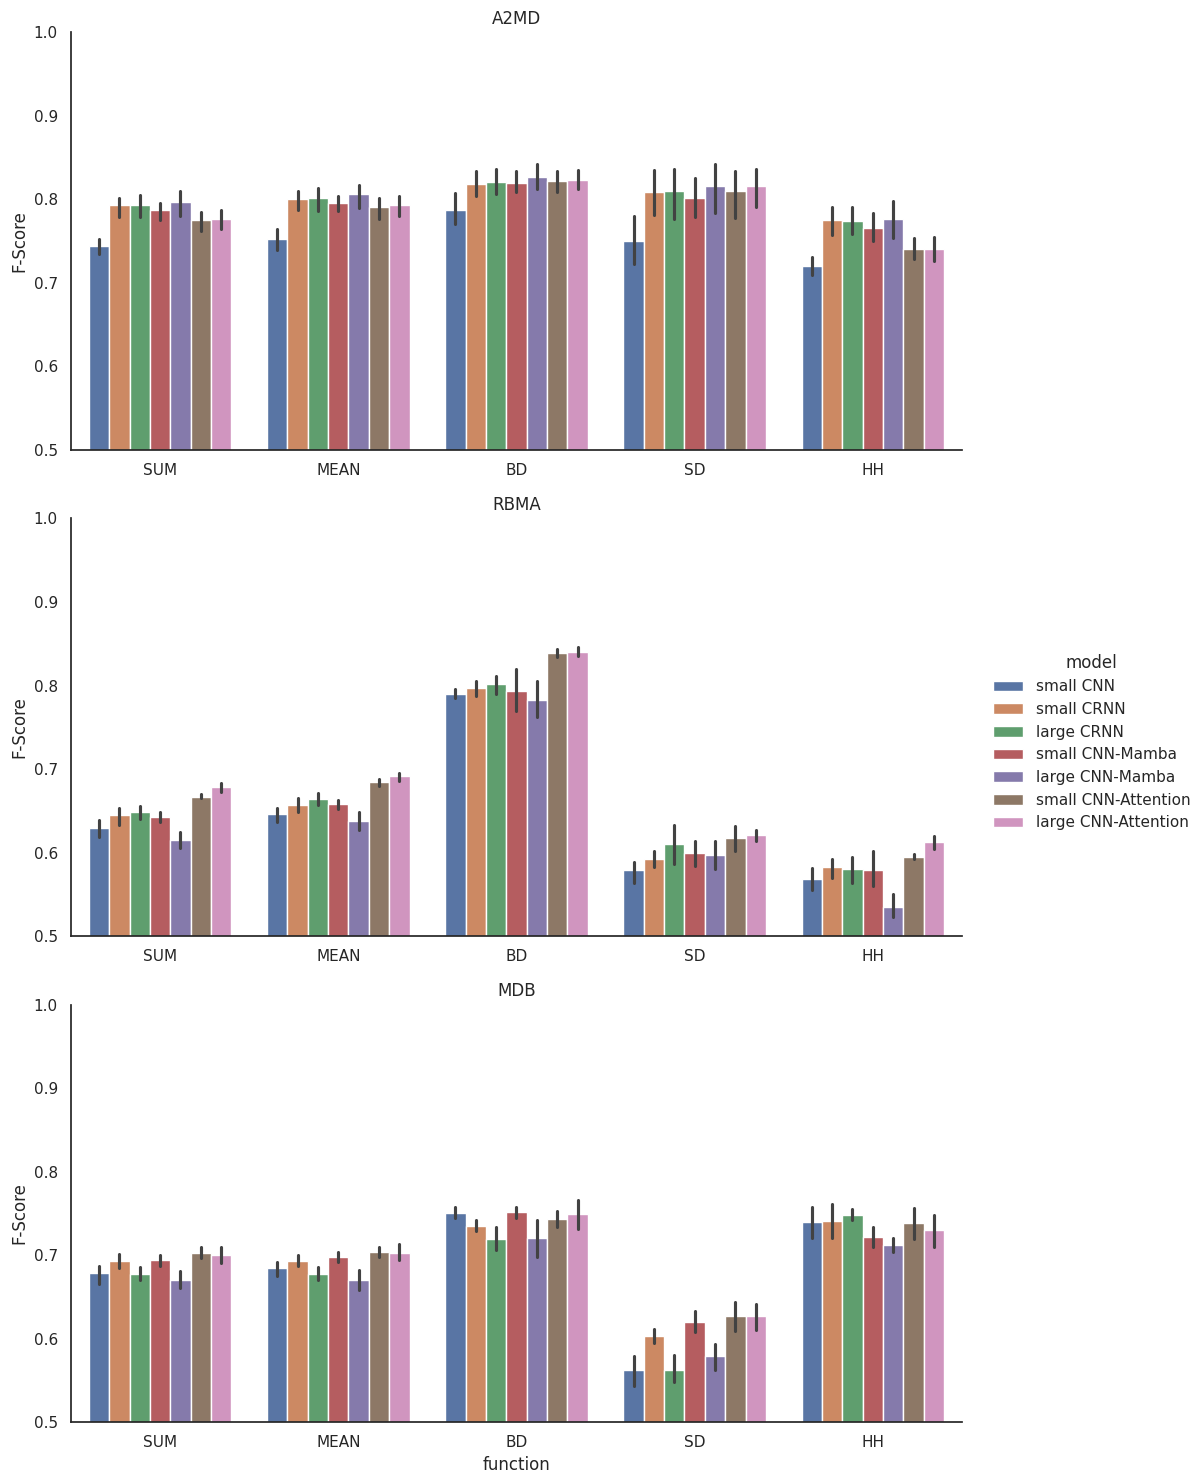

In [62]:
def scores_overview(data: pl.DataFrame):
    column_map = {
        f"F-Score/Sum/{cls}": cls for cls in ["BD", "SD", "HH"]
    }
    column_map["F-Score/Avg"] = "MEAN"
    column_map["F-Score/Sum/Total"] = "SUM"
    # data = data.filter(pl.col("dataset") == dataset)
    data = data.rename(column_map).select("model", "dataset", "fold", *column_map.values())
    data = data.unpivot(index=["model", "dataset", "fold"], variable_name="function", value_name="score")
    g = sns.catplot(
        kind="bar",
        x="function",
        y="score",
        hue="model",
        data=data,
        order=["SUM", "MEAN", "BD", "SD", "HH"],
        hue_order=[*name_map.values()],
        row="dataset",
        aspect=2,
        sharex=False,
    )
    g.set_ylabels("F-Score")
    for ax, ds in zip(g.axes, ["A2MD", "RBMA", "MDB"]):
        ax[0].set_ylim(0.5, 1)
        ax[0].set_title(ds)

        # ax[0].bar_label(ax[0].containers[0])

    g.tight_layout()
    return g

scores_overview(scores)
plt.savefig(f"processed/{experiment_name}/scores_overview.svg")


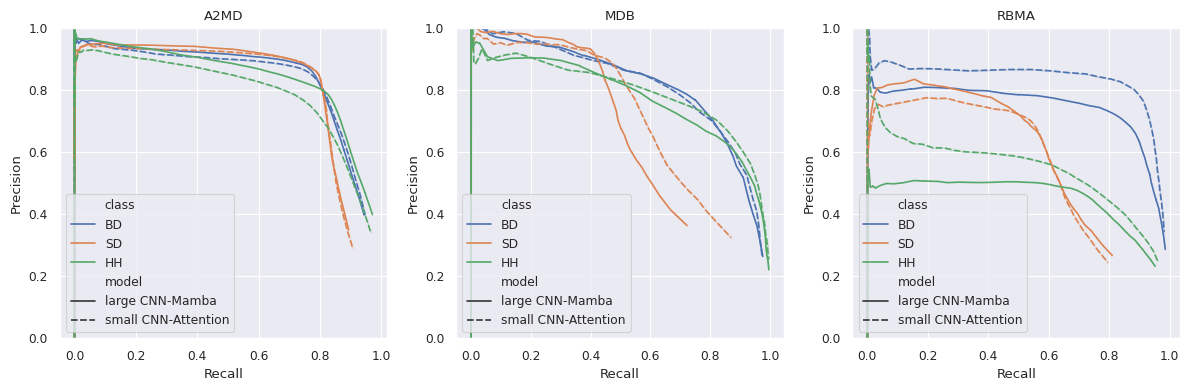

In [50]:
def pr_curve(data: pl.DataFrame, models, dataset, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    data = data.filter((pl.col("dataset") == dataset) & (pl.col("model").is_in(models)) & (pl.col("fold") == 0))
    sns.lineplot(x="recall", y="precision", hue="class", data=data, ax=ax, style="model")
    ax.set_ylim(0, 1)
    ax.set_title(dataset)
    sns.move_legend(ax, "lower left")
    return ax


fig, axes = plt.subplots(nrows=1, ncols=3)
for ax, ds in zip(axes, ["A2MD", "MDB", "RBMA"]):
    pr_curve(prft, ["large CNN-Mamba", "small CNN-Attention"], ds, ax=ax)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")

# fig.suptitle("F-Score vs. Threshold")
fig.set_size_inches(6 * 2, 2 * 2)
fig.tight_layout()
plt.savefig(f"processed/{experiment_name}/pr-mamba-vs-attention.svg")
plt.show()

0.5199999809265137
0.5900000333786011
0.550000011920929


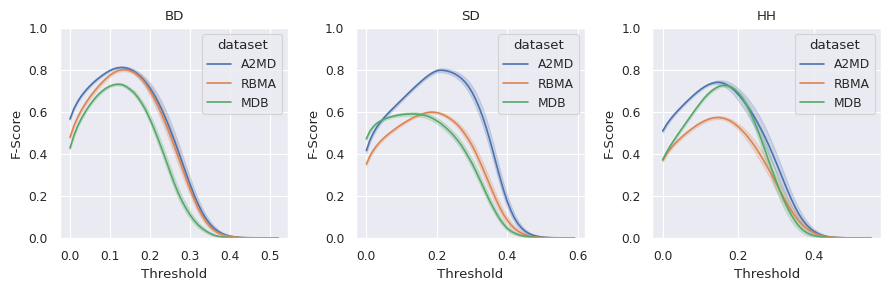

In [8]:
def f_thresh_plot(data, cls, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    data = data.filter(pl.col("class") == cls)
    max_threshold = data.filter(pl.col("f-score") > 0).select("threshold").max().to_numpy()[0, 0]
    data = data.filter(pl.col("threshold") <= max_threshold)
    sns.lineplot(x="threshold", y="f-score", hue="dataset", data=data, ax=ax, errorbar=("se", 2))
    ax.set_xlabel("Threshold")
    ax.set_ylabel("F-Score")
    ax.set_ylim(0, 1)
    ax.set_title(cls)
    return ax


classes = ["BD", "SD", "HH"]

fig, axes = plt.subplots(nrows=1, ncols=3)
for ax, cls in zip(axes, classes):
    f_thresh_plot(prft, cls, ax=ax)

# fig.suptitle("F-Score vs. Threshold")
fig.set_size_inches(6 * 1.5, 2 * 1.5)
fig.tight_layout()
plt.savefig(f"processed/{experiment_name}/threshold_curves.svg")


In [49]:
for ds, height in zip(["A2MD", "RBMA", "MDB"], [22, 25, 51]):
    g = sns.kdeplot(x="onset_error", data=errors.filter((pl.col("dataset") == ds) & (pl.col("time shift") == 0.02)), hue="class")
    plt.vlines(x=[0, 0.06], ymin=0, ymax=height, linestyles="dashed", color="grey")
    g.set_title(f"{ds} - time shift = 0.02")
    g.set_xlabel("distance from label (s)")

    plt.tight_layout()
    plt.savefig(f"processed/{experiment_name}/detection_onset_error_{ds}.svg")
    plt.close()

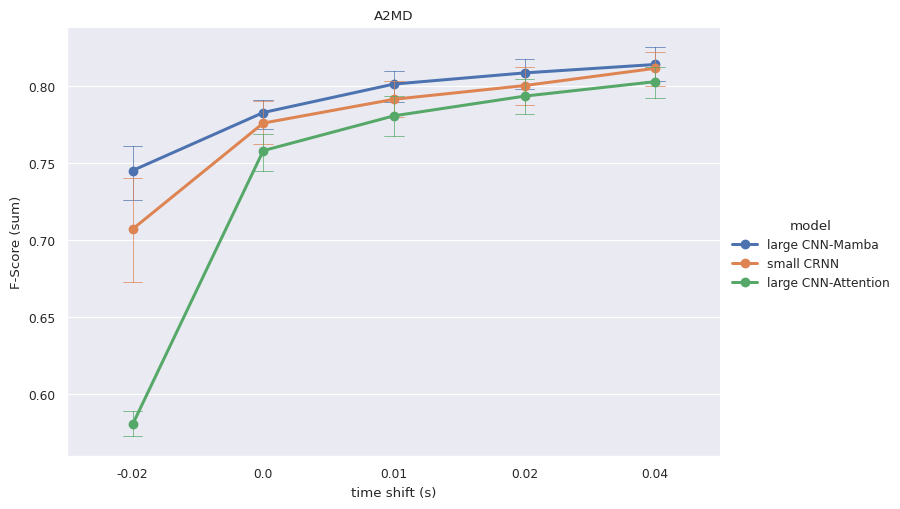

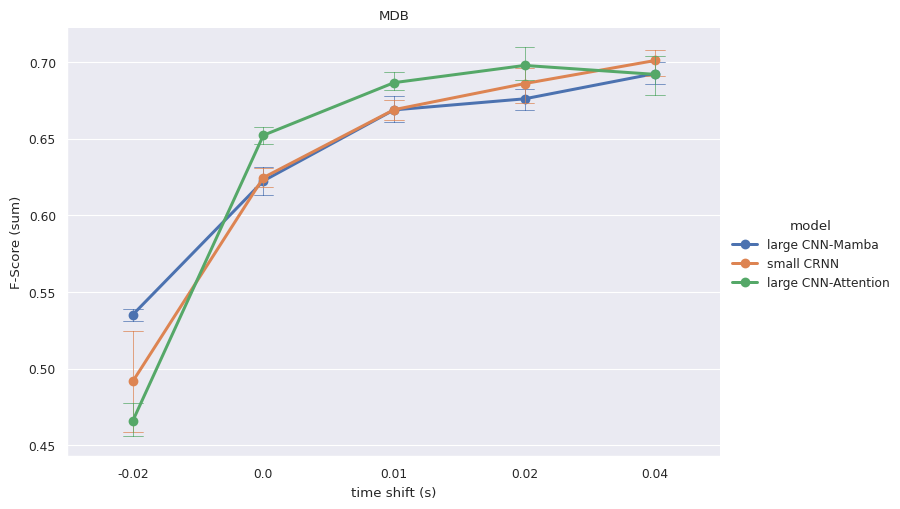

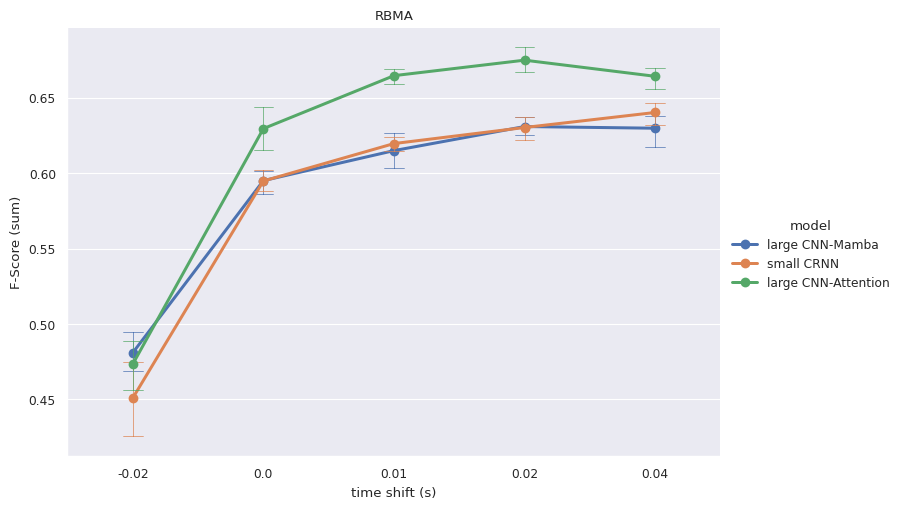

In [38]:
def time_shift_line(data: pl.DataFrame, dataset):
    column_map = {
        f"F-Score/Sum/{cls}": cls for cls in ["BD", "SD", "HH"]
    }
    column_map["F-Score/Avg"] = "mean"
    column_map["F-Score/Sum/Total"] = "sum"
    data = data.filter(pl.col("dataset") == dataset).rename(column_map).select("model", "dataset", "fold", "time shift", "sum")
    data = data.unpivot(index=["model", "dataset", "fold", "time shift"], variable_name="Aggregation", value_name="F-Score")
    #sns.lineplot(x="time shift", y="F-Score", hue="model", data=data, ax=ax, style="Aggregation", err_style="bars", err_kws={"alpha": 0.3})
    g = sns.catplot(kind="point" ,x="time shift", y="F-Score", hue="model", data=data, capsize=0.15, err_kws={'linewidth': 0.5}, aspect=1.5)
    g.ax.set_title(dataset)
    g.ax.set_xlabel("time shift (s)")
    g.ax.set_ylabel("F-Score (sum)")
    return g

for ds in ["A2MD", "MDB", "RBMA"]:
    time_shift_line(scores, ds)
    plt.savefig(f"processed/{experiment_name}/time_shift_curve_{ds}.svg")


/home/marclie/Documents/Uni/2024_SS/Bachelorarbeit/Automatic-Drum-Transcription/.venv/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/marclie/Documents/Uni/2024_SS/Bachelorarbeit/Automatic-Drum-Transcription/.venv/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/marclie/Documents/Uni/2024_SS/Bachelorarbeit/Automatic-Drum-Transcription/.venv/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/marclie/Documents/Uni/2024_SS/Bachelorarbeit/Automatic-Drum-T

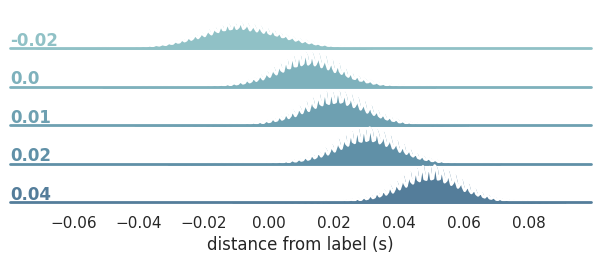

In [57]:
def plot_error_dist_across_shifts(data, dataset):
    data = data.filter(pl.col("dataset") == dataset)

    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(data, row="time shift", hue="time shift", aspect=15, height=.5, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "onset_error",
          bw_adjust=.5, clip_on=False,
          fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, "onset_error", clip_on=False, color="w", lw=2, bw_adjust=.5)

    # passing color=None to refline() uses the hue mapping
    g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)


    g.map(label, "time shift")

    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=0)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.set_xlabels("distance from label (s)")
    g.despine(bottom=True, left=True)
    plt.vlines([0, 0.06], 0, 1, linestyles="dashed", color="grey")

plot_error_dist_across_shifts(errors, "A2MD")
plt.savefig(f"processed/{experiment_name}/timing_error_overview_a2md.svg")